In [1]:
import sys, random
from pprint import pprint
from matplotlib import pyplot as plt

sys.path.append('../../..')
from model import run, processing, plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, dynamic_asset_fee, dynamic_lrna_fee, dynamicmult_lrna_fee, dynamicmult_asset_fee, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth, tx_processor
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

random.seed(42)

In [2]:


txs = processing.import_tx_data()

# init conditions, block 1,900,000
imbalance = -948.164768558685

TOKEN_METADATA = [
    ('HDX', 12),
    ('LRNA', 12),
    ('DAI', 18),
    ('WBTC', 8),
    ('WETH', 18),
    ('DOT', 10),
    ('APE', 18),
    ('USDC', 6),
    ('PHA', 12),
]
reserves = {}
lrna = {}
shares = {}
protocol_shares = {}

# {
#   hubReserve: 8,137,225,226,997,822
#   shares: 11,694,537,888,665,715,296
#   protocolShares: 983,155,502,336,092,024
#   cap: 70,000,000,000,000,000
#   tradable: {
#     bits: 15
#   }
# }
# {
#   nonce: 0
#   consumers: 0
#   providers: 6
#   sufficients: 0
#   data: {
#     free: 22,949,569,263,636,714,063
#     reserved: 0
#     miscFrozen: 0
#     feeFrozen: 0
#   }
# }


lrna['HDX'] = 8137.225226997822
shares['HDX'] = 11694537.888665715296
protocol_shares['HDX'] = 983155.502336092024
reserves['HDX'] = 22949569.263636714063

# {
#   hubReserve: 37,893,200,762,556,660
#   shares: 878,631,936,445,678,324,144,296
#   protocolShares: 101,444,243,838,007,848,170,805
#   cap: 450,000,000,000,000,000
#   tradable: {
#     bits: 15
#   }
# }
# Tokens
# {
#   free: 934,419,916,469,318,031,120,593
#   reserved: 0
#   frozen: 0
# }

lrna['DAI'] = 37893.200762556660
shares['DAI'] = 878631.936445678324144296
protocol_shares['DAI'] = 101444.243838007848170805
reserves['DAI'] = 934419.916469318031120593

# {
#   hubReserve: 24,354,480,024,223,513
#   shares: 2,646,425,158
#   protocolShares: 0
#   cap: 350,000,000,000,000,000
#   tradable: {
#     bits: 15
#   }
# }
# {
#   free: 2,629,936,223
#   reserved: 0
#   frozen: 0
# }

lrna['WBTC'] = 24354.480024223513
shares['WBTC'] = 2646.425158
protocol_shares['WBTC'] = 0
reserves['WBTC'] = 2629.936223

# {
#   hubReserve: 37,553,530,907,453,916
#   shares: 550,240,695,598,954,581,238
#   protocolShares: 63,778,166,208,550,944,760
#   cap: 450,000,000,000,000,000
#   tradable: {
#     bits: 15
#   }
# }
# {
#   free: 568,020,846,009,410,965,534
#   reserved: 0
#   frozen: 0
# }

lrna['WETH'] = 37553.530907453916
shares['WETH'] = 550240.695598954581238
protocol_shares['WETH'] = 63778.166208550944760
reserves['WETH'] = 568020.846009410965534

# {
#   hubReserve: 8,094,722,820,581,663
#   shares: 338,786,513,224,590
#   protocolShares: 2,541,140,642,776
#   cap: 800,000,000,000,000,000
#   tradable: {
#     bits: 15
#   }
# }
# {
#   free: 300,823,693,603,851
#   reserved: 0
#   frozen: 0
# }



lrna['DOT'] = 8094.722820581663
shares['DOT'] = 338786.513224590
protocol_shares['DOT'] = 2541.140642776
reserves['DOT'] = 300823.693603851



In [3]:
print(txs[0])

{'id': '0001900287-000002-ea2db', 'block_no': 1900287, 'tx_no': 2, 'type': 'sell', 'success': True, 'who': '0x6a3ead3a429f0f8d6d17efedbd57e0dd432b3bf6b739bee70976803d1e313119', 'fee': 1560001755092, 'tip': 0, 'asset_in': 'HDX', 'asset_out': 'DOT', 'amount_in': 5100.0, 'amount_out': 6.6970616296, 'limit_amount': 6.6300910134}


In [4]:
# reserves = {'HDX': hdx_reserves, 'DAI': dai_reserves, 'WBTC': wbtc_reserves, 'WETH': weth_reserves, 'DOT': dot_reserves}
tokens = {tkn: {'liquidity': reserves[tkn], 'LRNA': lrna[tkn]} for tkn in ['HDX', 'DAI', 'WBTC', 'WETH', 'DOT']}

omnipool = OmnipoolState(
    tokens=tokens,
    shares=shares,
    protocol_shares=protocol_shares,
    lrna_fee=0.0005,
    asset_fee=0.0025,
    preferred_stablecoin='DAI'
)

agents = {
    'tx_processor': Agent(
        holdings={'HDX': 1000000000, 'DAI': 1000000000, 'WBTC': 1000000000, 'WETH': 1000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
        trade_strategy=tx_processor('omnipool', txs)
    )
}

initial_state = GlobalState(
    pools={'omnipool': omnipool},
    agents=agents,
    initial_block= 1900000
)

time_steps = 220000
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)

Running with 220000 time steps
Starting simulation...
Execution time: 129.8 seconds.


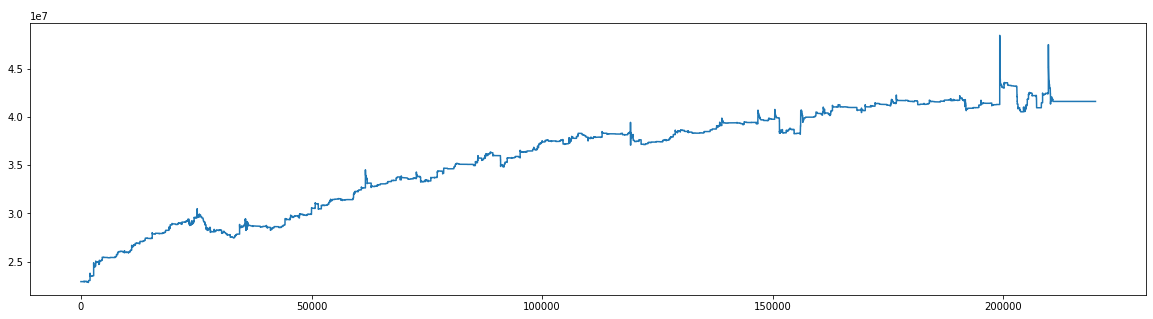

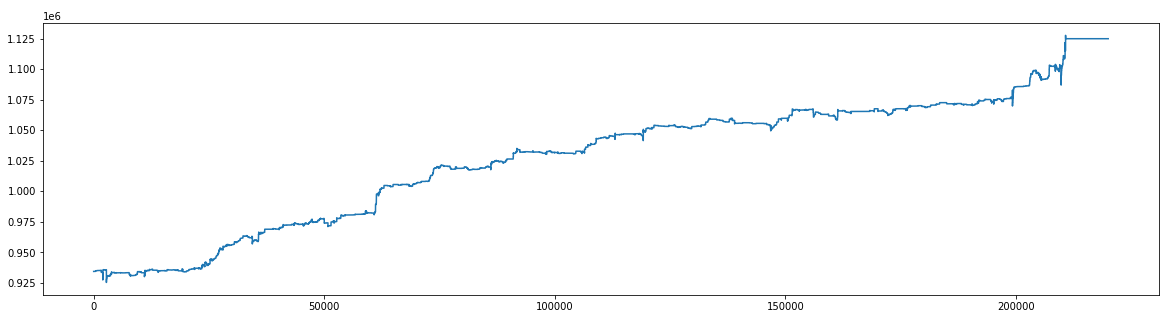

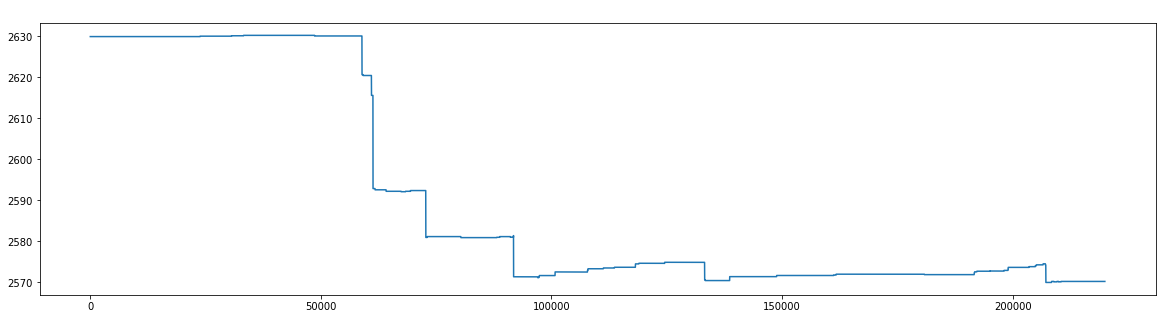

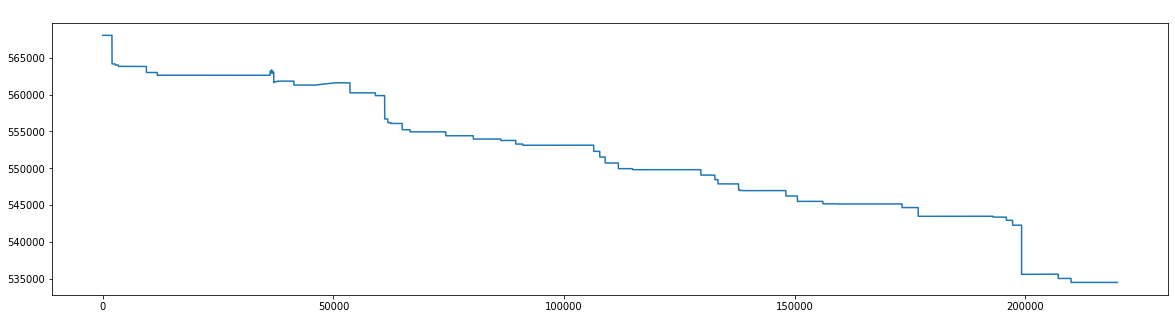

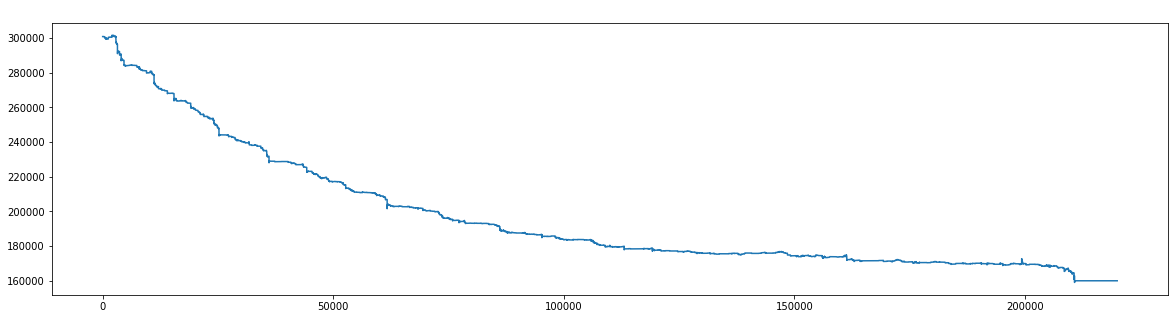

In [5]:
for tkn in initial_state.pools['omnipool'].asset_list:
    pu.plot([event['state'].pools['omnipool'].liquidity[tkn] for event in events])

In [6]:
pprint(events[-1]['state'].pools['omnipool'].liquidity)

{'DAI': mpf('1124893.5403423471016005947585938539670134243437050721'),
 'DOT': mpf('159972.76250743290951988189395946566185267896697714091'),
 'HDX': mpf('41594783.163700543759266964770258140474584472995556795'),
 'WBTC': mpf('2570.22014863757045188003289540009734782812869965605'),
 'WETH': mpf('534543.38913851188917234637114965685473028229966511781')}


In [7]:
pprint(events[0]['state'].pools['omnipool'].liquidity)

{'DAI': mpf('934419.916469317977316677570343017578125'),
 'DOT': mpf('300823.693603851017542183399200439453125'),
 'HDX': mpf('22949569.263636715710163116455078125'),
 'WBTC': mpf('2629.93622300000015457044355571269989013671875'),
 'WETH': mpf('568020.846009410917758941650390625')}
